# Project 4: Cell Nuclei Separation — Watershed

**Task:** Separate touching nuclei  
**Methods:** Marker-controlled watershed  
**Dataset:** Kaggle — Data Science Bowl Cell Nuclei  
**Compare:** With vs without markers  
**Learning:** Over-segmentation control

In [37]:
!pip install kaggle opencv-python scikit-image matplotlib numpy scipy

### Step 1: Download Dataset via Kaggle API
Ensure `kaggle.json` is uploaded or configured in `~/.kaggle/`.

In [38]:
import os
import zipfile

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 2>/dev/null || echo "Make sure kaggle.json is present."
!chmod 600 ~/.kaggle/kaggle.json 2>/dev/null

# Download a mirror of the Data Science Bowl 2018 dataset
!kaggle competitions download -c data-science-bowl-2018

if os.path.exists('data-science-bowl-2018.zip'):
    with zipfile.ZipFile('data-science-bowl-2018.zip', 'r') as zip_ref:
        zip_ref.extractall('DSB_2018')
        with zipfile.ZipFile('DSB_2018/stage1_train.zip', 'r') as zip_ref:
          zip_ref.extractall('DSB_2018/stage1_train')
    print("Dataset Extracted.")

data-science-bowl-2018.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset Extracted.


### Step 2: Import Libraries and Load Image

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import sobel, threshold_otsu
from skimage.color import label2rgb
from skimage.measure import label
import glob

# Find a good sample image containing touching nuclei
image_paths = glob.glob('DSB_2018/stage1_train/*/images/*.png')
if image_paths:
    # Select an image index that typically has dense clusters
    img_path = image_paths[4]

    # Load in grayscale
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Preprocessing: Otsu's Thresholding to get binary mask
    thresh_val = threshold_otsu(image)
    binary_mask = image > thresh_val

    # Fill small holes inside the nuclei
    binary_mask = ndi.binary_fill_holes(binary_mask)
else:
    print("Images not found. Check dataset extraction.")

### Step 3: Standard Watershed (Without Markers)
Applying watershed without markers usually means applying it to the gradient (edges) of the image. It will use every tiny local minimum as a starting basin, leading to massive over-segmentation.

In [40]:
if image_paths:
    # Calculate gradient (elevation map) using Sobel filters
    elevation_map = sobel(image)

    # Create a generic set of local minima based on the raw image
    # Because we don't use strict distance markers, it will over-segment
    markers_uncontrolled = np.zeros_like(image)
    markers_uncontrolled[image < thresh_val] = 1 # Background
    markers_uncontrolled[image > (thresh_val + 20)] = 2 # Foreground guess

    # Apply standard watershed
    segmentation_without_markers = watershed(elevation_map, markers_uncontrolled)

    # Alternatively, running it completely unsupervised on the mask gradient:
    # This shatters the objects entirely.
    distance_unfiltered = ndi.distance_transform_edt(binary_mask)
    local_maxi_unfiltered = peak_local_max(distance_unfiltered, footprint=np.ones((1, 1)), labels=binary_mask)
    mask_unfiltered = np.zeros(distance_unfiltered.shape, dtype=bool)
    mask_unfiltered[tuple(local_maxi_unfiltered.T)] = True
    markers_bad, _ = ndi.label(mask_unfiltered)
    labels_without_markers = watershed(-distance_unfiltered, markers_bad, mask=binary_mask)

### Step 4: Marker-Controlled Watershed
This is the correct approach. We compute the Distance Transform and mathematically identify the exact center of each nucleus to act as an unshakeable seed marker.

In [41]:
if image_paths:
    # 1. Distance Transform (Euclidean)
    distance = ndi.distance_transform_edt(binary_mask)

    # 2. Find local maxima (peaks) of the distance transform to serve as markers.
    # min_distance enforces that peaks must be separated by at least 'min_distance' pixels.
    # This is the key step to prevent over-segmentation!
    local_maxi = peak_local_max(distance, min_distance=7, labels=binary_mask)

    # 3. Label the markers uniquely
    marker_mask = np.zeros(distance.shape, dtype=bool)
    marker_mask[tuple(local_maxi.T)] = True
    markers_good, _ = ndi.label(marker_mask)

    # 4. Apply Marker-Controlled Watershed
    # We watershed the inverted distance map (-distance) so the peaks become valleys for water to pool in.
    labels_with_markers = watershed(-distance, markers_good, mask=binary_mask)

### Step 5: Visualization

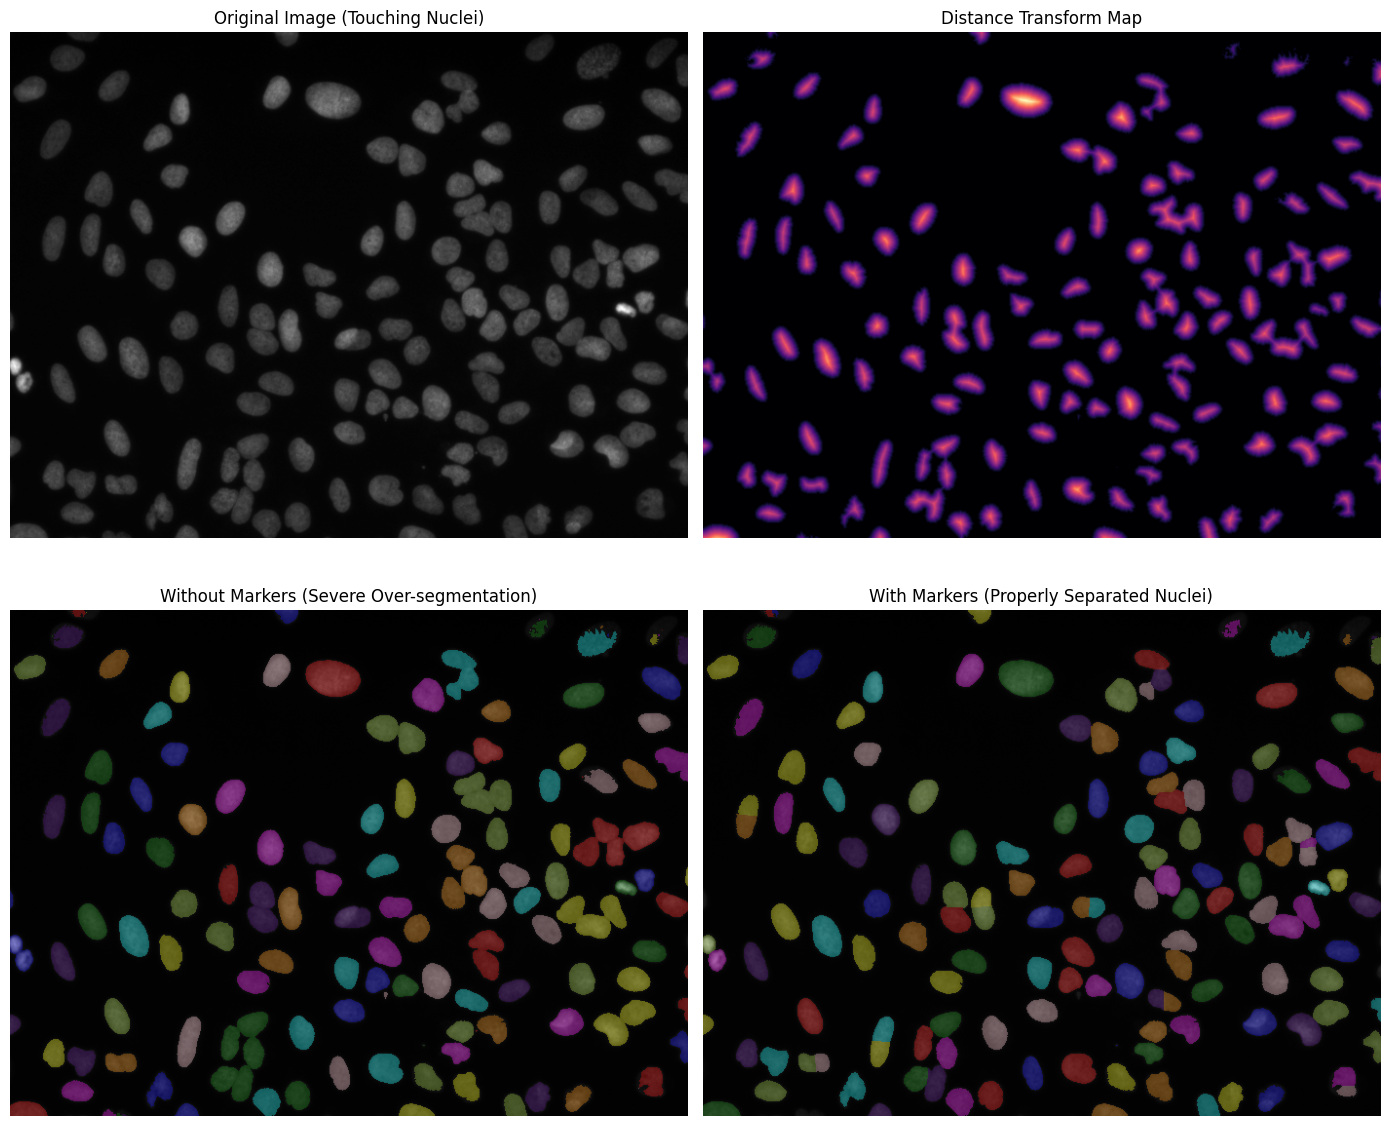

In [42]:
if image_paths:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    ax = axes.ravel()

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image (Touching Nuclei)')
    ax[0].axis('off')

    # Show the distance transform that makes the markers possible
    ax[1].imshow(distance, cmap='magma')
    ax[1].set_title('Distance Transform Map')
    ax[1].axis('off')

    # Colorize the labels to show the different segments clearly
    color_without = label2rgb(labels_without_markers, image=image, bg_label=0)
    ax[2].imshow(color_without)
    ax[2].set_title('Without Markers (Severe Over-segmentation)')
    ax[2].axis('off')

    color_with = label2rgb(labels_with_markers, image=image, bg_label=0)
    ax[3].imshow(color_with)
    ax[3].set_title('With Markers (Properly Separated Nuclei)')
    ax[3].axis('off')

    plt.tight_layout()
    plt.show()